## Agent wydawca

### Instalacja bibliotek

In [26]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [27]:
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Kto jest premierem Polski?")

print(web_search_results["results"][0]["content"])

Donald Tusk był już premierem Polski w latach 2007-14, potem dwukrotnie przewodniczącym Rady Europejskiej, a dziś jest liderem Koalicji


### Funkcje pomocnicze

In [29]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")


def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        # name może być None; type zwraca "human"/"ai"/"system"/"tool"
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    return "user", str(msg)


### Agent researcher

In [30]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def research_agent_node(state):
    messages = state["messages"]
    user_request = messages[0].content  # BaseMessage OK

    search_results = web_search.invoke(user_request)
    research_content = []
    for result in search_results["results"][:3]:
        research_content.append(f"Źródło: {result['url']}\nTreść: {result['content']}\n")
    research_text = "\n---\n".join(research_content)

    research_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Researcherem. Masz dostęp do fragmentów z 'wyszukiwarki' (RESEARCH).
Twoim celem jest dostarczyć rzeczowe, krótkie fakty i dane wspierające temat.
Odnoś się do fragmentów i nie fantazjuj. Pisz po polsku, zwięźle.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Temat: {topic}\n\nWyniki wyszukiwania:\n{research_data}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = research_prompt | model | StrOutputParser()
    response = chain.invoke({"topic": user_request, "research_data": research_text})

    return {"messages": [{"role": "assistant", "content": response, "name": "research_agent"}]}


### Agent autor

In [31]:
from langchain_core.messages import BaseMessage

def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    # fallback
    return "user", str(msg)


In [32]:
def author_agent_node(state):
    messages = state["messages"]
    has_critic_already_intervened = state.get("critic_marked", False)

    if has_critic_already_intervened:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem-Edytorem. Otrzymałeś już feedback od Krytyka i musisz poprawić swój tekst.
Przeanalizuj uwagi krytyka i dostarcz poprawioną wersję artykułu, która odpowiada na jego zastrzeżenia.
Uwzględnij wszystkie sugestie i wypełnij wskazane luki. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Historia konwersacji:\n{conversation_history}\n\nPopraw artykuł uwzględniając feedback krytyka.")
        ])
    else:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem. Z dostępnych faktów zaproponuj praktyczne rozwiązanie/plan.
Uwzględnij kroki, wymagania i minimalny zestaw decyzji. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Na podstawie researchu stwórz artykuł:\n{conversation_history}")
        ])

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = author_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    return {"messages": [{"role": "assistant", "content": response, "name": "author_agent"}]}


### Agent krytyk

In [33]:
def critic_agent_node(state):
    messages = state["messages"]

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    critic_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Krytykiem. Twoją rolą jest znaleźć luki, ryzyka i niejasności w propozycji.
Zadawaj dociekliwe pytania i wskaż brakujące elementy. Bądź konstruktywny.
Po przeanalizowaniu pracy autora, jeśli widzisz istotne braki lub problemy, zakończ swoją odpowiedź słowami: "needs improvement"
Jeśli praca jest zadowalająca i nie wymaga istotnych poprawek, zakończ słowami: "approved"
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Przeanalizuj pracę autora:\n{conversation_history}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = critic_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    updates = {
        "messages": [{"role": "assistant", "content": response, "name": "critic_agent"}]
    }
    if not state.get("critic_marked", False):
        updates["critic_marked"] = True  # pierwsza ingerencja krytyka

    return updates


def should_continue(state):
    last = state["messages"][-1]
    _, content = _name_and_content(last)
    content = content.lower()
    return "author_agent" if "needs improvement" in content else "end"

In [34]:
# --- REKOMPILACJA GRAFU (to kluczowe!) ---
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class WorkflowState(TypedDict):
    messages: Annotated[list, add_messages]
    critic_marked: bool

supervisor = (
    StateGraph(WorkflowState)
    .add_node("research_agent", research_agent_node)
    .add_node("author_agent", author_agent_node)
    .add_node("critic_agent", critic_agent_node)
    .add_edge(START, "research_agent")
    .add_edge("research_agent", "author_agent")
    .add_edge("author_agent", "critic_agent")
    .add_conditional_edges("critic_agent", should_continue, {
        "author_agent": "author_agent",
        "end": END
    })
    .compile(debug=True)
)


### Wyświetl graf

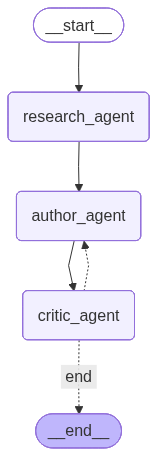

In [35]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

### Uruchom graf i wygeneruj artykuł

In [36]:
# --- URUCHOMIENIE ---
for chunk in supervisor.stream(
    {
        "messages": [{
            "role": "user",
            "content": "Wygeneruj artykuł na temat: Jak zbudować aplikację agenta 'Wydawcy' w oparciu o bibliotekę LangGraph",
        }],
        "critic_marked": False,
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)


[values] {'messages': [HumanMessage(content="Wygeneruj artykuł na temat: Jak zbudować aplikację agenta 'Wydawcy' w oparciu o bibliotekę LangGraph", additional_kwargs={}, response_metadata={}, id='9299dfae-5f80-4210-a60c-5fabad982349')], 'critic_marked': False}
[updates] {'research_agent': {'messages': [{'role': 'assistant', 'content': 'Budowanie aplikacji agenta "Wydawcy" z użyciem biblioteki LangGraph obejmuje kilka kroków:\n\n1. Wykorzystanie API LangGraph do projektowania doświadczeń użytkownika opartych na agentach. LangGraph dostarcza infrastrukturę do szybkiego wdrażania i skalowania aplikacji (źródło: www.langchain.com/langgraph).\n\n2. Nauka korzystania z LangGraph poprzez kursy dostępne na academy.langchain.com. Kursy obejmują lekcje na temat motywacji, studia LangGraph, Chain, Router, Agent, Agent with Memory, wprowadzenia do wdrażania, schematu stanu, reduktorów stanu, strumieniowania, punktów przerwania, równoległości, sklepu LangGraph, schematu pamięci + profilu, schematu 